<a href="https://colab.research.google.com/github/YusunPark/DeepLearning/blob/main/3_3%ED%8A%B9%EC%84%B1%EA%B3%B5%ED%95%99%EA%B3%BC%EA%B7%9C%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 특성 공학과 규제
148p

- 기존의 특성을 사용해 새로운 특성을 뽑아내는 작업을 `특성공학`
  - 농어 길이 x 농어 높이 라는 새로운 특성


- 선형회귀는 특성이 많을수록 좋은 결과를 낸다.

### 다중회귀
- 여러개의 특성을 사용한 선형 회귀
- 1개의 특성 -> 직선을 학습
- 2개의 특성 -> 평면을 학습

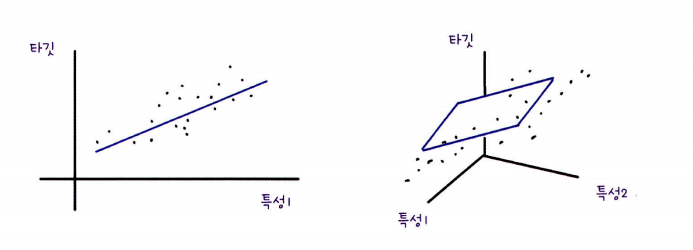

## 데이터 준비

In [30]:
import pandas as pd

In [31]:
df = pd.read_csv('https://bit.ly/perch_csv_data')
perch_full = df.to_numpy()
print(perch_full[:5])

[[ 8.4   2.11  1.41]
 [13.7   3.53  2.  ]
 [15.    3.82  2.43]
 [16.2   4.59  2.63]
 [17.4   4.59  2.94]]


In [32]:
df.head()

,length,height,width
0,8.4,2.11,1.41
1,13.7,3.53,2.00
2,15.0,3.82,2.43
3,16.2,4.59,2.63
4,17.4,4.59,2.94


In [33]:
import numpy as np

perch_weight = np.array(
    [5.9, 32.0, 40.0, 51.5, 70.0, 100.0, 78.0, 80.0, 85.0, 85.0, 
     110.0, 115.0, 125.0, 130.0, 120.0, 120.0, 130.0, 135.0, 110.0, 
     130.0, 150.0, 145.0, 150.0, 170.0, 225.0, 145.0, 188.0, 180.0, 
     197.0, 218.0, 300.0, 260.0, 265.0, 250.0, 250.0, 300.0, 320.0, 
     514.0, 556.0, 840.0, 685.0, 700.0, 700.0, 690.0, 900.0, 650.0, 
     820.0, 850.0, 900.0, 1015.0, 820.0, 1100.0, 1000.0, 1100.0, 
     1000.0, 1000.0]
     )

In [34]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    perch_full, perch_weight, random_state=42)

## 사이킷런의 변환기

In [35]:
from sklearn.preprocessing import PolynomialFeatures

In [36]:
# 2개의 특성으로 이루어진 샘플을 변환
# 변환기는 target데이터 없이 입력데이터를 변환한다.
poly = PolynomialFeatures()
poly.fit([[2, 3]])
print(poly.transform([[2, 3]]))

[[1. 2. 3. 4. 6. 9.]]


In [37]:
# include_bias=False : 절편에 해당하는 (항상 1임) 특성을 제거
# 그러면 input으로 넣은 값의 제곱, 곱셈 값이 반환
poly = PolynomialFeatures(include_bias=False)
poly.fit([[2, 3]])
print(poly.transform([[2, 3]]))

[[2. 3. 4. 6. 9.]]


In [38]:
# 위의 방식으로 input 데이터를 변환
poly = PolynomialFeatures(include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)
print(train_poly.shape)

(42, 9)


In [39]:
# get_feature_names() : 9개의 특성이 각각 어떤 조합으로 만들어졌는지 알려줌
poly.get_feature_names()

['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']

In [40]:
test_poly = poly.transform(test_input)

## 다중 회귀 모델 훈련하기

In [41]:
# 특성을 추가함으로써  -> 과소적합 문제 해결
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_poly, train_target)
print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))

0.9903183436982124
0.9714559911594132


In [42]:
# degree=5로 설정해서 5제곱까지 추가 -> 특성 55개
poly = PolynomialFeatures(degree=5, include_bias=False)

poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)
print(train_poly.shape)

(42, 55)


In [43]:
# train은 거의 완벽한데, test는 아주 큰 음수가 나왔다.
# -> 너무 과대적합되어서 테스트 세트에서는 형편없는 점수
lr.fit(train_poly, train_target)
print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))

0.9999999999991096
-144.40579242335605


## 규제
156p
- 머신러닝 모델이 훈련 세트를 너무 과도하게 학습하지 못하도록 훼방하는 것
  - 선형 회귀 모델의 경우, 특성에 곱해지는 계수(또는 기울기)의 크기를 작게 만드는 일

- 특성의 스케일이 정규화되지 않으면, 여기에 곱해지는 계수 값도 차이나게 된다.


### 규제의 종류
- 릿지
- 라쏘

선형 회귀 모델에 규제를 추가한 모델을 `릿지 ridge`와 `라쏘 lasso`라고 부릅니다.<br>
두 모델은 규제를 가하는 방법이 다릅니다.<br>
릿지는 계수를 제곱한 값을 기준으로 규제를 적용하고,<br>
라쏘는 계수의 절댓값을 기준으로 규제를 적용합니다.
일반적으로 릿지를 조금 더 선호합니다.<br>
두 알고리즘 모두 계수의 크기를 줄이지만 라쏘는 아예 0으로 만들 수도 있습니다.<br>
물론 사이킷런은 이 두 알고리즘을 모두 제공합니다.

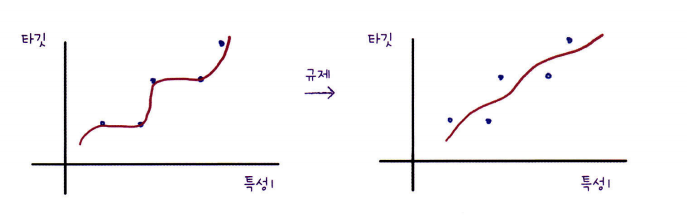

In [58]:
# 꼭 훈련세트로 학습한 변환기를 사용해서 테스트 세트까지 변환해주어야 한다.
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_poly)
train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

print(train_scaled.shape)
print(test_scaled.shape)

(42, 55)
(14, 55)


## 릿지

In [45]:
# 릿지를 이용해서 규제를 줌
# -> 55개의 특성임에도, 과대적합되지 않아 테스트세트에서 좋은 성능
# alpha값을 이용해서 규제 강도를 조절가능

from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(train_scaled, train_target)
print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9896101671037343
0.9790693977615396


In [46]:
# 적절한 alpha값은 R^2 값 그래프를 그려보면 안다.
# 훈련세트와 테스트 세트의 점수가 가장 가까운 지점이 최적

import matplotlib.pyplot as plt

train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
  ridge = Ridge(alpha=alpha)
  ridge.fit(train_scaled, train_target)
  train_score.append(ridge.score(train_scaled, train_target))
  test_score.append(ridge.score(test_scaled, test_target))

No handles with labels found to put in legend.


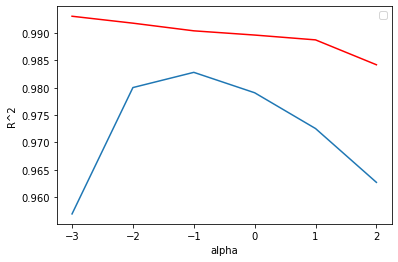

In [47]:
plt.plot(np.log10(alpha_list), train_score, color='red')
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()
plt.show()

In [48]:
ridge = Ridge(alpha=0.1)
ridge.fit(train_scaled, train_target)

print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9903815817570366
0.9827976465386916


## 라쏘

- 라쏘 모델은 계수 값을 아예 0으로 만들 수 있다.
  - 라쏘 모델의 계수는 coef_ 속성에 저장되어있다.
  - 계수가 0이라는 것의 의미 : 특성이 유용하지 않다는 의미


In [49]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(train_scaled, train_target)
print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.9897898972080961
0.9800593698421883


In [50]:
# 라쏘도 릿지처럼 alpha 값을 바꿀 수 있다.
# max_iter : 라쏘모델 훈련시 ConvergenceWarning 경고 발생 가능하다.
# -> 사이킷런의 라쏘 모델은 최적의 계수를 찾기 위해 반복적인 계산을 수행하는데,
# -> 지정한 반복 횟수가 부족할 때 경고 발생 -> max_iter로 반복횟수를 늘려주었다.

train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
  lasso = Lasso(alpha=alpha, max_iter=10000)
  lasso.fit(train_scaled, train_target)

  train_score.append(lasso.score(train_scaled, train_target))
  test_score.append(lasso.score(test_scaled, test_target))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18778.697957792876, tolerance: 518.2793833333334
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12972.821345404844, tolerance: 518.2793833333334
  positive)


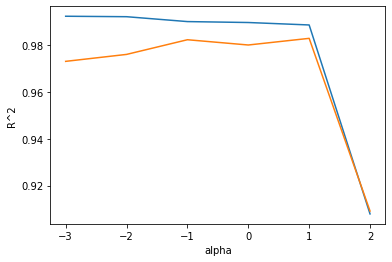

In [51]:
# 여기서 최적의 alpha 값은 1 =>  10^1 = 10 이다.
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

In [52]:
lasso = Lasso(alpha=10)
lasso.fit(train_scaled, train_target)

print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.9888067471131867
0.9824470598706695


In [53]:
# coef_ : 라쏘모델의 계수를 저장하고 있다.
# 계수 = 0 => 모델 제작에 해당 특성이 도움이 안된다.
# 따라서 55개중 40개의 특성은 필요없는 것이다.

print(np.sum(lasso.coef_ == 0))

40


In [54]:
poly.get_feature_names()

['x0',
 'x1',
 'x2',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x1^2',
 'x1 x2',
 'x2^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x2^2',
 'x1^3',
 'x1^2 x2',
 'x1 x2^2',
 'x2^3',
 'x0^4',
 'x0^3 x1',
 'x0^3 x2',
 'x0^2 x1^2',
 'x0^2 x1 x2',
 'x0^2 x2^2',
 'x0 x1^3',
 'x0 x1^2 x2',
 'x0 x1 x2^2',
 'x0 x2^3',
 'x1^4',
 'x1^3 x2',
 'x1^2 x2^2',
 'x1 x2^3',
 'x2^4',
 'x0^5',
 'x0^4 x1',
 'x0^4 x2',
 'x0^3 x1^2',
 'x0^3 x1 x2',
 'x0^3 x2^2',
 'x0^2 x1^3',
 'x0^2 x1^2 x2',
 'x0^2 x1 x2^2',
 'x0^2 x2^3',
 'x0 x1^4',
 'x0 x1^3 x2',
 'x0 x1^2 x2^2',
 'x0 x1 x2^3',
 'x0 x2^4',
 'x1^5',
 'x1^4 x2',
 'x1^3 x2^2',
 'x1^2 x2^3',
 'x1 x2^4',
 'x2^5']

In [55]:
lasso.coef_

array([ 0.        ,  0.        ,  0.        , 12.14852453, 55.44856399,
       42.23100799,  0.        ,  0.        , 13.70596191,  0.        ,
       43.2185952 ,  5.7033775 , 47.46254536,  7.42309425, 11.85823365,
        0.        ,  0.        , 13.53038193, 21.22111356,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       18.66993032,  0.        ,  0.        ,  0.        , 15.81041778,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 18.14672268,
        0.        ,  0.        ,  0.        ,  0.        , 15.51272953,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [56]:
mask = lasso.coef_ != 0
mask

array([False, False, False,  True,  True,  True, False, False,  True,
       False,  True,  True,  True,  True,  True, False, False,  True,
        True, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False])

In [57]:
feature_names = np.array(poly.get_feature_names())
print(feature_names[mask])

['x0^2' 'x0 x1' 'x0 x2' 'x2^2' 'x0^2 x1' 'x0^2 x2' 'x0 x1^2' 'x0 x1 x2'
 'x0 x2^2' 'x1 x2^2' 'x2^3' 'x0 x1^3' 'x1^4' 'x0 x1^4' 'x1^5']


머신러닝에서 주로 하는 일 <br>
: 최적의 하이퍼파라미터를 찾는 일